# Twitter Regression

### Dependencies

In [126]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from pymongo import MongoClient
import pymongo
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.neural_network import MLPRegressor
%matplotlib inline

### MongoDB Connection

In [18]:
# Connecto to Local DB
client = MongoClient()
db = client.test
collection = db.screen_name
data = pd.DataFrame(list(collection.find()))

In [25]:
data

,Tweets,_id,description,screen_name
0,"[{'favorite_count': 45255.0, 'full_text': 'As ...",5aea74e51f8fed2de43ae649,45th President of the United States of America🇺🇸,realDonaldTrump
1,"[{'favorite_count': 0.0, 'full_text': 'RT @Mic...",5aea75891f8fed2de43ae64a,"Dad, husband, President, citizen.",BarackObama


For simplicity, debbugging and testing we will be using the realDonaldTrump.jsonl for future analysis. But notice that is posible to retrieve the information from the local DB.

## Data Cleaning  & Feature Selection

In [203]:
df = pd.read_json('realDonaldTrump.jsonl', lines=True)

We drop the columns with empty values and columns with the same value since those are not representative of the data. Due to the API own limitations and the poor performance of my laptop, we will attempt to do data analysis this way. Ideally the more datapoints the better, specially with neural networks.

In [204]:
df.dropna(axis=1,inplace=True)
df.head(3)

,created_at,display_text_range,entities,favorite_count,favorited,full_text,id,id_str,is_quote_status,lang,retweet_count,retweeted,source,truncated,user
0,2018-05-03 00:53:30,"[0, 162]","{'symbols': [], 'urls': [], 'hashtags': [], 'u...",45255,False,"As everybody is aware, the past Administration...",991843153953964033,991843153953964032,False,en,11050,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'has_extended_profile': False, 'is_translatio..."
1,2018-05-02 22:40:23,"[0, 278]","{'symbols': [], 'urls': [], 'hashtags': [], 'u...",56018,False,“This isn’t some game. You are screwing with t...,991809653980966913,991809653980966912,False,en,15520,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'has_extended_profile': False, 'is_translatio..."
2,2018-05-02 20:27:47,"[0, 280]","{'symbols': [], 'urls': [], 'hashtags': [], 'u...",65729,False,I have been briefed on the U.S. C-130 “Hercule...,991776286489169920,991776286489169920,False,en,15092,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'has_extended_profile': False, 'is_translatio..."


After all the cleaning we have left 5 features to work on.

In [209]:
df= df[['created_at','display_text_range','favorite_count','full_text','retweet_count']]
df['tweet_lenght']= df['display_text_range'].apply(lambda arr: arr[1])
x = df.drop(['display_text_range','retweet_count','favorite_count','full_text'], axis=1)   # Input Feature Matrix

In [211]:
y_retweet = df['retweet_count'] #1 Output 
y_fav = df['favorite_count']    #2 Output
x.head()

,created_at,tweet_lenght
0,2018-05-03 00:53:30,162
1,2018-05-02 22:40:23,278
2,2018-05-02 20:27:47,280
3,2018-05-02 18:16:56,27
4,2018-05-02 14:45:54,247


In [236]:
df.describe()

,favorite_count,retweet_count,tweet_lenght
count,400.000000,400.000000,400.000000
mean,82806.352500,20667.055000,190.317500
std,42092.684794,10502.946801,80.686445
min,0.000000,1165.000000,0.000000
25%,64690.750000,14552.250000,138.750000
50%,84114.500000,19384.500000,202.000000
75%,102573.000000,24870.750000,273.000000
max,361198.000000,108680.000000,315.000000


# Feature Extraction

We will attempt to do an exploratory test on the data to see how it behaves and have a better understanding on what we are dealing with.

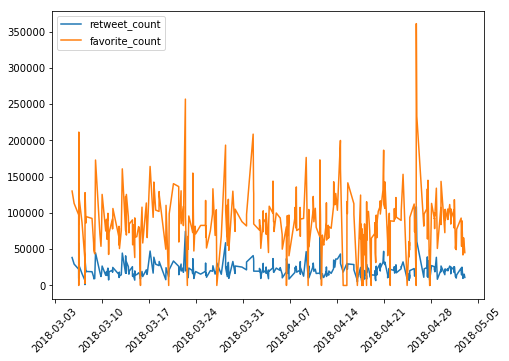

In [245]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(df['created_at'],y_retweet)
axes.plot(df['created_at'],y_fav)
plt.xticks(rotation=45)
axes.legend(loc=0)
plt.show()

Moreover, we could do a simple regression on the Tweet lenght and the total count, this is a simple approach but we want to do a more significant analysis.

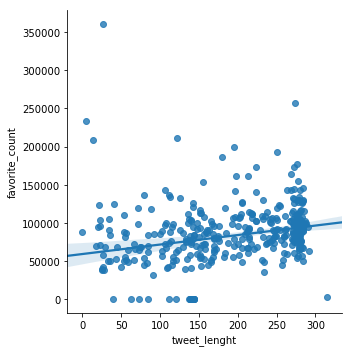

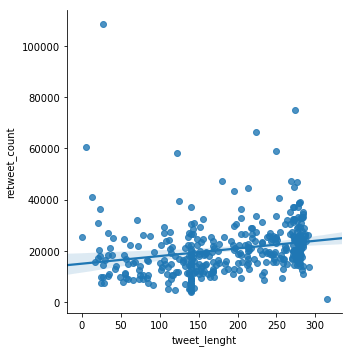

In [243]:
sns.lmplot(x='tweet_lenght',y='favorite_count',data=df)
sns.lmplot(x='tweet_lenght',y='retweet_count',data=df)
plt.show()

From these graphs we can notice that both our outputs are higly correlated and are both normal distributed. The plot below shows how these two matches an almost perfect diagonal, which makes sense because we often see similar amount on both.

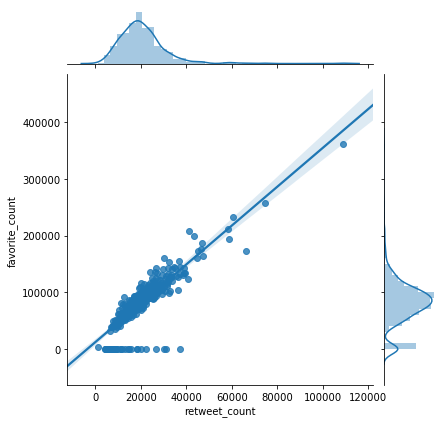

In [235]:
g = sns.JointGrid(x='retweet_count',y='favorite_count',data=df)
g = g.plot(sns.regplot, sns.distplot)

For a more complex analysis we came with the hypothesis that the content of the Tweet could be responsible of the # of likes and retweets. For example, if Donald Trump is tweeting "USA is going to war with North Korea" we expect that the total count of likes to be increased. For a more realistic approach we would also need to do an analysis on other features such as location, pictures attached, #hastaghs. ets. For such approaches a huge amount of data is required as well as GPU power to perform CNN for the image classification and some NLP techniques like sentiment analysis and data minning. In this study we will limit our expectations on the use of Tweet_Text only.

# Model

To begin with, we need to split our data into a set of inputs and outputs. For a better generalisation it is recommended to ALWAYS do CV on the data. For this challenge we will limit to 30% of the total data as our test set and the rest for trainning.

In [246]:
X_train, X_test, y_train, y_test = train_test_split(df['full_text'], y_retweet, test_size=0.3, random_state=0)
vectorizer = TfidfVectorizer(stop_words='english',token_pattern = r'\b[a-zA-Z]{3,}\b',lowercase = True)
X_train_tfidf = vectorizer.fit_transform(X_train) 

For this excercise we will implement a TfidfVectorizer with unigram features. The document term matrix will contain the features of our model for prediction. Due to the sparce matrix resulting it makes sense to use a SVR. SRVs have the quality to generalise well on small datapoints and they have also shown that they can deal with high dimentions with ease, which is our case.

In [265]:
svr= SVR(kernel='rbf')
svr.fit(X_train_tfidf, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [266]:
X_test_tfidf = vectorizer.transform(X_test)
y_pred_train = svr.predict(X_train_tfidf)
y_pred_test = svr.predict(X_test_tfidf)

## Evaluation

In [267]:
MSE_train=mean_squared_error(y_train, y_pred_train)
MSE_test=mean_squared_error(y_test, y_pred_test)

print("Training Set MSE:               {:.2f}".format((MSE_train)))
print("Test Set MSE:                   {:.2f}".format((MSE_test)))


Training Set MSE:               111223532.53
Test Set MSE:                   112714406.43


At a glance it seems that our MSE error is huge (not normalized), but it will make sense once we see the plot below. The regressor tries to best fit the line that contains most of the datapoints for prediction. The red line denotes the predicted #likes and compares them with the actual value (green). As you can see, our data does not follow any explicit pattern and is well scatter all over the plot. The numerical value in most of the cases the #likes is a large amount, every time it calculates the error (prediction-real) it will show a great amount, thus the large MSE error. The same procedure can be done for the #retweets.

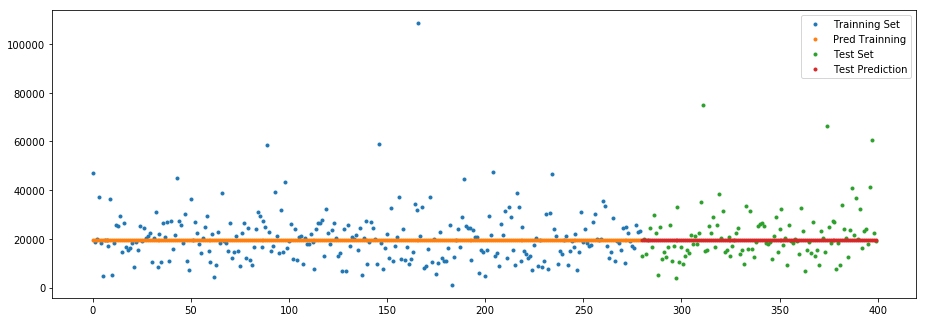

In [268]:
x_plot= np.arange(0,X_train.shape[0])
x_plot_test= np.arange(X_train.shape[0],X_test.shape[0]+X_train.shape[0])
fig = plt.figure(figsize=(12,4))
axes = fig.add_axes([0,0,1,1])
plt.scatter(x_plot,y_train, marker='.', label="Trainning Set")
plt.scatter(x_plot,y_pred_train, marker='.', label="Pred Trainning")
plt.scatter(x_plot_test,y_test, marker='.',label="Test Set")
plt.scatter(x_plot_test,y_pred_test, marker='.',label="Test Prediction")
axes.legend(loc=0)
plt.show()